In [1]:
import pandas as pd
import dataprovider_pypots as dp
import process_edited as pce
import matplotlib.pyplot as plt
import torch

## Load Data

In [2]:
data = 'dataset/energy_data'
filename = f'{data}.csv'
real_df = pd.read_csv(filename)

real_df = real_df # You can load entire data if your memory is sufficient! 
real_df1 = real_df.drop(['date'], axis=1)
parser = pce.DataFrameParser().fit(real_df1, 1)
column_name = parser.column_name()
processed_data = torch.from_numpy(parser.transform())

data_dict = dp.TVMCG(real_df.iloc[0:2000,:], 
                     train_ratio=0.8, 
                     val_ratio=0.1, 
                     test_ratio=0.1, 
                     seq_len = 24, 
                     stride = 1, 
                     column_list=column_name, 
                     target_column=["lights", "rv1"])

## Train TimeAutoDiff

In [3]:
import VAE as vae
import DIFF as diff_mod   # DIFF 모듈

VAE_training = 10000; diff_training = 10000; lat_dim = 6; 

############ Parameter Setting ############
# pip install ipywidgets
n_epochs = VAE_training; eps = 1e-5
weight_decay = 1e-6; lr = 2e-4; hidden_size = 512; num_layers = 2; batch_size = 100
channels = 64; min_beta = 1e-5; max_beta = 0.1; emb_dim = 128; time_dim = 8; threshold = 1; device = 'cuda'

############ Auto-encoder Training ############
ds = vae.train_autoencoder_best_train(
    None,
    channels,
    hidden_size,
    num_layers,
    lr,
    weight_decay,
    n_epochs,
    batch_size,
    threshold,
    min_beta,
    max_beta,
    emb_dim,
    time_dim,
    lat_dim,
    device,
    data_dict,
)
latent_features = ds[1]

############ Diffusion Training ############
n_epochs = diff_training; hidden_dim = 200; num_layers = 2; diffusion_steps = 100; num_classes = len(latent_features)
num_classes = len(latent_features)
diff_model = diff_mod.train_diffusion(
    latent_features,
    None,
    data_dict,
    hidden_dim,
    num_layers,
    diffusion_steps,
    n_epochs,
    num_classes,
)

Output()

Output()

## Inference

In [6]:
import numpy as np
import DIFF as Diff

Batch_size, Seq_len, _ = data_dict["response_train"].shape
Lat_dim = lat_dim

base_target_mask = data_dict["target_mask_train"]
base_target = data_dict["response_train"]
base_cond = data_dict["cond_train"]
base_time_info = data_dict["time_info_train"]
cat_num_classes = data_dict["cat_num_classes_idx"]
parser = data_dict['parser']

# Sampling process
device = 'cuda'
diffusion_steps = 100
Lat_dim = lat_dim
t_grid = torch.linspace(0, 1, Seq_len).view(1, -1, 1).to(device)
samples = Diff.sample(
    t_grid.repeat(Batch_size, 1, 1),
    Batch_size,
    Seq_len,
    Lat_dim,
    diffusion_steps,
    diff_model,
    base_time_info,
    base_cond,
    base_target_mask.float().to(device),
)

# Process the generated data
gen_output = ds[0].decoder(samples.to(device), base_target_mask, base_cond)
_synth_data = pce.convert_to_tensor(parser, gen_output, 1, Batch_size, Seq_len)

## Draw the predicted column

C:\Users\namjo\AppData\Local\Temp\ipykernel_12104\141243352.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='upper left')


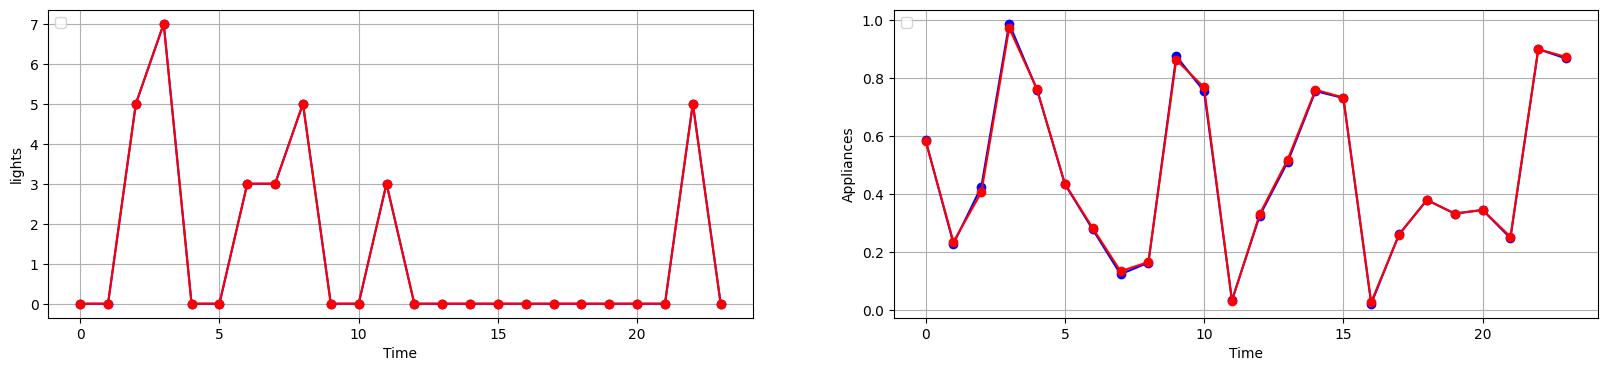

In [7]:
label = 1 # 10/6/2012 - Saturday
##################################################################################################################
# plot label's time series snapshot
target_column = ["lights", "rv1"]
fig, axes = plt.subplots(1, len(target_column), figsize=(20, 4)) 
target_idx = data_dict["target_idx"]

_synth_data = _synth_data[:,:,target_idx]
target_test = base_target[:,:,target_idx]

# Plot histogram for the specified column
for i in range(0,len(target_column)):
    axes[i].plot(target_test[label,:,i],  marker='o', linestyle='-', color='b')
    axes[i].plot(_synth_data[label,:,i].cpu(),  marker='o', linestyle='-', color='r')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(f'{column_name[i]}')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

plt.show()
